In [1]:
# ------------------------
## ----import libraries
# ------------------------
import os,sys
import numpy as np
# xarray
import xarray as xr
# plot
import matplotlib.image as image
from matplotlib.offsetbox import OffsetImage,AnchoredOffsetbox

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import matplotlib.cm as cm


In [2]:
from dask.distributed import Client
c = Client()
c

/linkhome/rech/genlop01/uor98hu/.local/lib/python3.9/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33697 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:33697/status,
Dashboard: http://127.0.0.1:33697/status,Workers: 5
Total threads: 10,Total memory: 20.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35315,Workers: 5
Dashboard: http://127.0.0.1:33697/status,Total threads: 10
Started: Just now,Total memory: 20.00 GiB
Comm: tcp://127.0.0.1:33287,Total threads: 2
Dashboard: http://127.0.0.1:33713/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:39985,


In [3]:
# read grid files
diri="/gpfswork/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I/"
mesh = xr.open_dataset(diri+'mesh_hgr.nc').squeeze()
tmask = mesh.tmask.isel(nav_lev=0) # grille lat/lon
nav_lon = mesh['nav_lon']
nav_lat = mesh['nav_lat']
e1t = mesh['e1t']
e2t = mesh['e2t']
cellArea=e1t*e2t

In [4]:
path = "/gpfsstore/rech/cli/rcli002/eORCA025.L75/eORCA025.L75-I"
chunk_size = {"time_counter":1}

In [5]:
# greenland runoff
dsrnf = xr.open_mfdataset(path+"/eORCA025.L75_1m_greenland_rnfbis_y*.nc", chunks=chunk_size).sel(time_counter=slice('1980','2018'))
rnfmask = dsrnf.socoefr
gr_rnf = dsrnf.sorunoff

maskrnf = xr.where(rnfmask[0]!=0,1,0)

In [6]:
# greenland isf
dsisf = xr.open_mfdataset(path+"/eORCA025.L75_1m_greenland_isfbis_y*.nc", chunks=chunk_size).sel(time_counter=slice('1980','2018'))
sornfisf = dsisf.sornfisf

sumisf = sornfisf.sum('time_counter')
maskisf = xr.where(sumisf!=0,1,0)


In [7]:
dsicb = xr.open_mfdataset(path+"/eORCA025.L75_1m_greenland_calvingbis_y*.nc", chunks=chunk_size).sel(time_counter=slice('1980','2018'))
soicbclv = dsicb.soicbclv

sumicb = soicbclv.sum('time_counter')
maskixccb = xr.where(sumicb!=0,1,0)


In [8]:
# combinbaison des masks

In [9]:
masktot = maskixccb + maskisf + maskrnf

In [10]:
maskrns_isf = maskisf + maskrnf

In [11]:
maskisf_icb = maskixccb + maskisf

In [12]:
maskicb_rnf = maskixccb  + maskrnf

In [13]:
# préparation du masque final
typesmask3 = xr.where(masktot==3,1,0) # points ou on a les 3; plot : masktot.where(masktot==3)
# points ou on a les 2; plot : masktot.where(masktot==2)
# points ou on a  1; plot : masktot.where(masktot==1) c'est que du rnf

In [14]:
# point ou on a que 2 type de sources; (tous sont du style icb+rnf)
masktot2 = masktot.where(masktot==2)
maskicb_rnf2 = maskicb_rnf.where(maskicb_rnf==2)
mask_only_rnf_icb = masktot2 + maskicb_rnf2

In [15]:
# point ou on a que 1 type de sources;
masktot1 = masktot.where(masktot==1)
maskrnf1 = maskrnf.where(maskrnf==1)
maskisf1 = maskisf.where(maskisf==1)
maskixccb1 = maskixccb.where(maskixccb==1)

mask_only_rnf = masktot1 + maskrnf1 # 38 pt
mask_only_isf = masktot1 + maskisf1# 0 pt
mask_only_icb = masktot1 + maskixccb1 # 0 pt

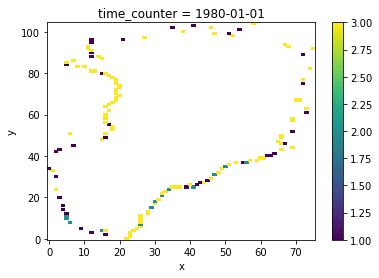

In [16]:
masktot.where(masktot!=0,drop=True).plot()

In [17]:
# they have all characteristicsc
#sizearray = xr.DataArray(data=8* np.ones(( 1207, 1442)),dims=["y", "x"],)
# markersizelmasks = sizearray.where(masktot==3)


In [18]:
dep_gr = xr.open_dataset(diri+'eORCA025.L75_y1950-2020_1m_greenland_isfbis.nc')
dep_gr_min = dep_gr.sozisfmin
dep_gr_max = dep_gr.sozisfmax

# PLOT

In [19]:
#vue polaire
loncentr=320 
latcentr=70
sath=2085831

In [20]:
#========= CREATE FIGURE
diro = "/gpfsscratch/rech/cli/uor98hu/PLOTS/"
namo  ="figS1.png"
print(namo)
#===========================================
trdata  = ccrs.PlateCarree() # Data system proj (if coords are in lat lon, use PlateCarre here)
proj = ccrs.NearsidePerspective(central_longitude=loncentr, central_latitude=latcentr,satellite_height=sath)
extent = [-57,-25,58,84] # (x0, x1, y0, y1)

#========= stylme de freshwater discharge

fig, (axa,axb) = plt.subplots(1, 2,figsize=(18,10),facecolor='none', dpi=72*2,subplot_kw={'projection': proj})
plt.subplots_adjust(wspace=0, hspace=0.1)

axa.set_extent(extent)

cl2 = axa.add_feature(cfeature.LAND.with_scale('50m'),facecolor="none",edgecolor='k',alpha=1, zorder=5, linewidth=0.5)

axa.pcolormesh(nav_lon, nav_lat, masktot.where(masktot!=0), transform=trdata, cmap='viridis') # markersizelmasks.T) #where(dep_gr_max!=0)


#========= DEPTH GLACIERS

axb.set_extent(extent)

cl2 = axb.add_feature(cfeature.LAND.with_scale('50m'),facecolor="none",edgecolor='k',alpha=1, zorder=5, linewidth=0.5)

cs = axb.pcolormesh(nav_lon, nav_lat, dep_gr_max.where(dep_gr_max!=0),cmap =cm.Reds, transform=trdata)
              
cbar = fig.colorbar(cs)
cbar.ax.tick_params(labelsize=14)
cbar.set_label(r'Depth of the grounding line [$m$]', fontsize=20)


axa.text(-0.035, 0.98, 'a)', fontsize=24, horizontalalignment='center', verticalalignment='center', transform=axa.transAxes)
axb.text(-0.035, 0.98, 'b)', fontsize=24, horizontalalignment='center', verticalalignment='center', transform=axb.transAxes)

# plt.show()
# fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight') #,edgecolor='none', 

fig.savefig(diro+namo, facecolor=fig.get_facecolor(), bbox_inches='tight',edgecolor='none') 
plt.close(fig)

figS1.png


/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
/gpfslocalsup/pub/anaconda-py3/2020.11/envs/climate_science/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1597: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  X, Y, C, shading = self._pcolorargs('pcolormesh', *args,
